In [20]:
import numpy as np 
import matplotlib.pyplot as plt 

In [21]:
import torch 
from torch.autograd import Function
from  torchvision import datasets, transforms 
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F

In [22]:
import qiskit
from qiskit import transpile, assemble 
from qiskit.visualization import *


In [25]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [26]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.46


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

Backward and forward propogation using the qunatum classical class 


In [46]:
class HybridFunction(Function):
    
    def forward(ctx,input,quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)
        
        return result
    
    def backward(ctx, grad_output):
        
        input,expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift 
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None 

class Hybrid(nn.Module):
    
    def __init__(self,backend,shots,shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1,backend,shots)
        self.shift = shift
    
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)
        
        


In [47]:
#Data Loading and Pre processing 

In [48]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

IndexError: index -7 is out of bounds for axis 0 with size 6

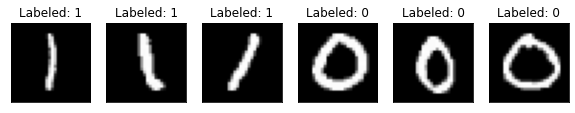

In [49]:
n_samples_show = 6

data_iter = iter(train_loader)
fig,axes = plt.subplots(nrows = 1, ncols= n_sampes_show, figsize = (10,3))

while n_sampes_show > 0:
    images,targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [50]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [51]:
#Creating the hybrid neural Network 

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6, kernel_size = 5)
        self.conv2 = nn.Conv2d(6,16, kernel_size = 5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64,1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi/2)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = self.dropout(x)
        x = x.view(1,-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x,1-x), -1)


In [52]:
#training the network 
model = Net()
optimizer = optim.Adam(model.parameters(), lr= 0.01)
loss_func = nn.NLLLoss()

epochs = 25
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
        
        

/tmp/ipykernel_23335/1735144580.py:28: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [4%]	Loss: -0.6346
Training [8%]	Loss: -0.8469
Training [12%]	Loss: -0.8805
Training [16%]	Loss: -0.9042
Training [20%]	Loss: -0.9097
Training [24%]	Loss: -0.8994
Training [28%]	Loss: -0.9480
Training [32%]	Loss: -0.9467
Training [36%]	Loss: -0.9257
Training [40%]	Loss: -0.9401
Training [44%]	Loss: -0.9590
Training [48%]	Loss: -0.9672
Training [52%]	Loss: -0.9513
Training [56%]	Loss: -0.9585
Training [60%]	Loss: -0.9709
Training [64%]	Loss: -0.9516
Training [68%]	Loss: -0.9447
Training [72%]	Loss: -0.9642
Training [76%]	Loss: -0.8564
Training [80%]	Loss: -0.8451
Training [84%]	Loss: -0.9612
Training [88%]	Loss: -0.9577
Training [92%]	Loss: -0.9556
Training [96%]	Loss: -0.9530
Training [100%]	Loss: -0.9744


Text(0, 0.5, 'Neg Log Likelihood Loss')

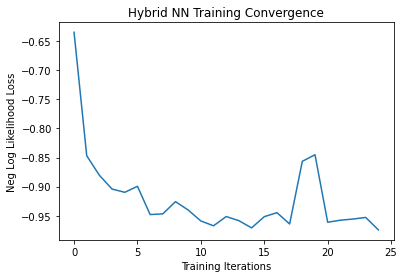

In [54]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [55]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.9779
	Accuracy: 99.0%


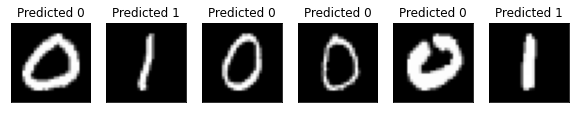

In [56]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1